In [1]:
import hashlib
import os
import tarfile
import zipfile
import requests
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt

DATA_HUB = dict()
DATA_URL = "http://d2l-data.s3-accelerate.amazonaws.com/"

In [2]:
def download(name, cache_dir=os.path.join('..', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


In [3]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)


In [4]:
train_data = pd.read_csv('./dataset/train.csv')
test_data = pd.read_csv('./dataset/test.csv')

In [5]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

去除第一个标签：`id`

In [6]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

## 预处理

连续值进行标准化，转为 0 均值和单位方差的数据

In [7]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)


离散值进行独热码处理，并且将 `na` 也是为一个有效的分类

In [8]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape


(2919, 331)

In [9]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)


## 开始训练

In [29]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(
        nn.Linear(in_features, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
        nn.Linear(30, 30),
        nn.ReLU(),
        nn.Linear(30, 1)
    )

    def init_weight(m: nn.Linear):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)
            nn.init.zeros_(m.bias)

    net.apply(init_weight)
    return net

使用对数误差

In [11]:
def log_rmse(net, features, labels):
    # 将小于 1 的值设置为 1（截尾）
    # torch.clamp 可以实现 [a, b] 之间的截尾
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds), torch.log(labels)))

    return rmse.item() # 将 1x1 张量转换为数值

In [12]:
import numpy as np

log_rmse(lambda t: t ** 2, torch.Tensor([2]), torch.Tensor([1.5])), np.log(2 ** 2) - np.log(1.5)

(0.9808292388916016, 0.9808292530117262)

In [13]:
import d2l.torch as d2l
from torch.utils import data

In [14]:
def train(net, train_features, train_labels, test_features, test_labels,
          epochs, lr, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = data.DataLoader(
        data.TensorDataset(train_features, train_labels), batch_size, shuffle=True
    )
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(epochs):
        for x, y in train_iter:
            optimizer.zero_grad()
            y_hat = net(x)
            l = loss(y_hat, y) # 依然用方均误差
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

定义 $K$ 折交叉验证函数：在 $K$ 折交叉验证中返回第 $i$ 折的数据

In [15]:
def get_k_fold_data(k: int, i: int, x: torch.Tensor, y: torch.Tensor):
    assert k > 1, "K must be a integer greater than 1!"
    fold_size = x.shape[0] // k
    x_train, y_train = None, None
    for j in range(k):
        # 产生索引对象
        idx = slice(j * fold_size, (j + 1) * fold_size)
        x_part, y_part = x[idx, :], y[idx]
        if j == i:
            x_valid, y_valid = x_part, y_part
        elif x_train is None:
            x_train, y_train = x_part, y_part
        else:
            x_train = torch.cat([x_train, x_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return x_train, y_train, x_valid, y_valid

定义 $k$ 折交叉训练函数

In [16]:
def k_fold(k, x_train, y_train, epochs, lr, weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        fold_data = get_k_fold_data(k, i, x_train, y_train)
        net = get_net() # 生成新网络，避免与之前的参数混淆
        train_ls, valid_ls = train(
            net, *fold_data, epochs, lr, weight_decay, batch_size 
        )
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')

        print(f"Fold {i + 1}, train log rmse {float(train_ls[-1])}, validation log rmse {float(valid_ls[-1])}")
    return train_l_sum / k, valid_l_sum / k

## 开始训练

Fold 1, train log rmse 7.534154891967773, validation log rmse 7.5465497970581055
Fold 2, train log rmse 8.974020004272461, validation log rmse 8.979344367980957
Fold 3, train log rmse 7.168815612792969, validation log rmse 7.186123847961426
Fold 4, train log rmse 8.26194953918457, validation log rmse 8.216411590576172
Fold 5, train log rmse 7.611719608306885, validation log rmse 7.621974468231201
训练平均：7.910131931304932，验证平均：7.910080814361573


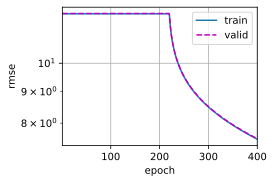

In [30]:
k, num_epochs, lr, weight_decay, batch_size = 5, 400, 10, 0, 256
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f"训练平均：{float(train_l)}，验证平均：{float(valid_l)}")

In [18]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)


训练log rmse：2.051863


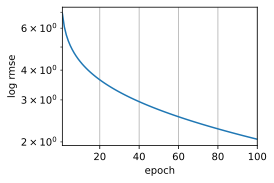

In [19]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)